As you might have noticed, torch leaves many responsibilities to the user regarding choices of device, writing of the training loop, loss logging and model checkpointing. This is good and bad at the same time since it provides a lot of flexibility, but re-writing lots of boilerplate code which will be very similar across projects.

[Pytorch_lightning](https://lightning.ai/docs/pytorch/stable/) aims to make many things easier by abstracting them from the user. It automatically handles devices, logs to tensorboard, offers plugins for model checkpointing, makes restoration of models from checkpointing easier and is able to manage distributed training across multiple GPUs or multiple nodes. In this notebook, we will modify the existing code using this library.

In [1]:
import pytorch_lightning as pl
import torch

from pathlib import Path
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
# we can have lightning take care of fixing random seeds for numpy, torch and cuda to ensure reproducibility of the trained models
pl.seed_everything(seed=42)

Global seed set to 42


42

In [3]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 0 	chosen device: cpu 	use_cuda= False


In [4]:
from torch.utils.data import DataLoader
from data import DSBData, get_dsb2018_train_files

In [5]:
from monai.networks.nets import BasicUNet

In [6]:
train_img_files, train_lbl_files = get_dsb2018_train_files()

train_data = DSBData(
    image_files=train_img_files,
    label_files=train_lbl_files,
    target_shape=(256, 256)
)

print(len(train_data))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:16<00:00, 22.85it/s]

232


Using lightning requires us to build a new neural network model by inheriting from the base class. This basically means to re-order parts of the existing code base into various member functions that have to be overridden.

In [7]:
class SegmentationNetwork(pl.LightningModule):
    def __init__(self, 
                 features=[16, 16, 32, 64, 128, 16],
                 activation="relu",
                 normalization="batch",
                 dropout=0.25
                ):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = BasicUNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            features=features,
            act=activation,
            norm=normalization,
            dropout=dropout,
        )
        self.output_activation = torch.nn.Sigmoid()
        self.loss_function = torch.nn.BCEWithLogitsLoss(reduction="mean")
    
    def forward(self, x):
        logits = self.model(x)
        prediction = self.output_activation(logits)  # apply the sigmoid to get a value in [0, 1] for each pixel

        return {
            'logits': logits,
            'prediction': prediction
        }

    def training_step(self, batch, batch_idx):
        # NOTE: no manual device mapping is required, lightning does that for you!
        X, y = batch
        pred_dict = self(X)

        batch_loss = self.loss_function(pred_dict["logits"], y)
        self.log("train_loss", batch_loss, prog_bar=True)

        return batch_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1.e-3)

In [8]:
model = SegmentationNetwork()
print(model)

BasicUNet features: (16, 16, 32, 64, 128, 16).
SegmentationNetwork(
  (model): BasicUNet(
    (conv_0): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (D): Dropout(p=0.25, inplace=False)
          (A): ReLU()
        )
      )
      (conv_1): Convolution(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (D): Dropout(p=0.25, inplace=False)
          (A): ReLU()
        )
      )
    )
    (down_1): Down(
      (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (convs): TwoConv(
        (conv_0): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [9]:
init_params = list(model.parameters())[0].clone().detach()

Now we set up a checkpoint callback that takes care of storing model weights and define a trainer instance which will manage running the training loop and device handling for us.

In [10]:
logfolder = Path("lightning_outputs")
if not logfolder.is_dir():
    logfolder.mkdir()

ckpt_callback = ModelCheckpoint(
    filename='{epoch:03.0f}-{train_loss:.3f}',
    save_last=True,
    save_top_k=1,
    monitor="train_loss",
    every_n_epochs=1
)

max_nepochs = 3
log_interval = 1

trainer = pl.Trainer(
    default_root_dir=logfolder,
    max_epochs=max_nepochs,
    log_every_n_steps=log_interval,
    accelerator="gpu" if use_cuda else "cpu",
    devices=ndevices if use_cuda else 1,
    callbacks=[
        ckpt_callback
    ]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
%load_ext tensorboard
%tensorboard --port 6006 --logdir ./lightning_outputs

In [12]:
trainer.fit(model, train_dataloaders=train_loader)

Missing logger folder: lightning_outputs/lightning_logs

  | Name              | Type              | Params
--------------------------------------------------------
0 | model             | BasicUNet         | 495 K 
1 | output_activation | Sigmoid           | 0     
2 | loss_function     | BCEWithLogitsLoss | 0     
--------------------------------------------------------
495 K     Trainable params
0         Non-trainable params
495 K     Total params
1.984     Total estimated model params size (MB)
/home/starke88/miniconda3/envs/torch_intro/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Restoration of model states from checkpoints is a bit easier than before as well, because it does not require you to re-create a model instance with the same hyperparameters as the checkpointed model (which might be unknown when only the checkpoint is available).

In [13]:
final_params = list(model.parameters())[0].clone().detach()
assert not torch.allclose(init_params, final_params)

# when to reload chkp, e.g. for doing inference
model_from_ckpt = SegmentationNetwork.load_from_checkpoint(
    ckpt_callback.last_model_path
)
loaded_params = list(model_from_ckpt.parameters())[0].cpu()
assert torch.allclose(loaded_params, final_params)

BasicUNet features: (16, 16, 32, 64, 128, 16).


## Look at some predictions

Now that the model has been trained for a little bit, we are looking at the predictions again. Usually model training has to be peformed longer, so don't expect any wonders. Also keep in mind that the predictions here are based on the data the model was trained on. Those predictions might be far better than those on data not used during training. But this is a story for later.

In [14]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Predictions')

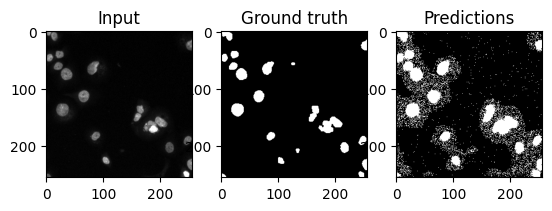

In [15]:
# we get a batch of data
for batch in train_loader:
    X, y = batch
    break

# convert to 0/1 range on each pixel
prediction_dict = model_from_ckpt(X.to(model_from_ckpt.device))
prediction = prediction_dict["prediction"]
prediction_binary = (prediction > 0.5).to(torch.uint8)

sidx = 0
plt.subplot(131)
plt.imshow(X[sidx, 0].numpy(), cmap="gray")
plt.title("Input")

plt.subplot(132)
plt.imshow(y[sidx, 0].numpy(), cmap="gray")
plt.title("Ground truth")

plt.subplot(133)
plt.imshow(prediction_binary.detach()[sidx, 0].cpu().numpy(), cmap="gray")
plt.title("Predictions")